## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [1]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [3]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, HoltWinters
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse, rel_mse, mqloss
from hierarchicalforecast.methods import TopDown, BottomUp
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

import pickle
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
from qgridnext import show_grid
from importlib import reload

In [7]:
TEST_PERIODS = 4

In [48]:
Y_df_load = (
    pd.read_parquet("revenue_data.parquet").rename({"value": "y"}, axis=1).reset_index()
)


Y_df_load["y"] = (
    Y_df_load["y"] / 1e6
)  # make everything in millions so its easier to read

## Prep Data

In [51]:
# last date
last_date = pd.to_datetime(date(2023, 9, 30))

In [52]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [53]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [54]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [55]:
# Get rid of companies for which we do not have enough data
MINIMUM_NUMBER_OF_OBSERVATIONS = 40
Y_df_load = Y_df_load.groupby("ticker").filter(
    lambda x: x.shape[0] > MINIMUM_NUMBER_OF_OBSERVATIONS
)

In [56]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [57]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [58]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [59]:
Y_df_load["entity_type"] = "company"

## Build training data

In [60]:
levels = [
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]


levels = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "ticker"],
]

levels = [
    ["top_level_SIC_code"],
    ["top_level_SIC_code", "second_level_SIC_code"],
    ["top_level_SIC_code", "second_level_SIC_code", "ticker"],
]

In [61]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=levels)

In [62]:
Y_df = Y_df.reset_index()

In [63]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [64]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4), Naive()], freq="QE", n_jobs=-1)

In [65]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


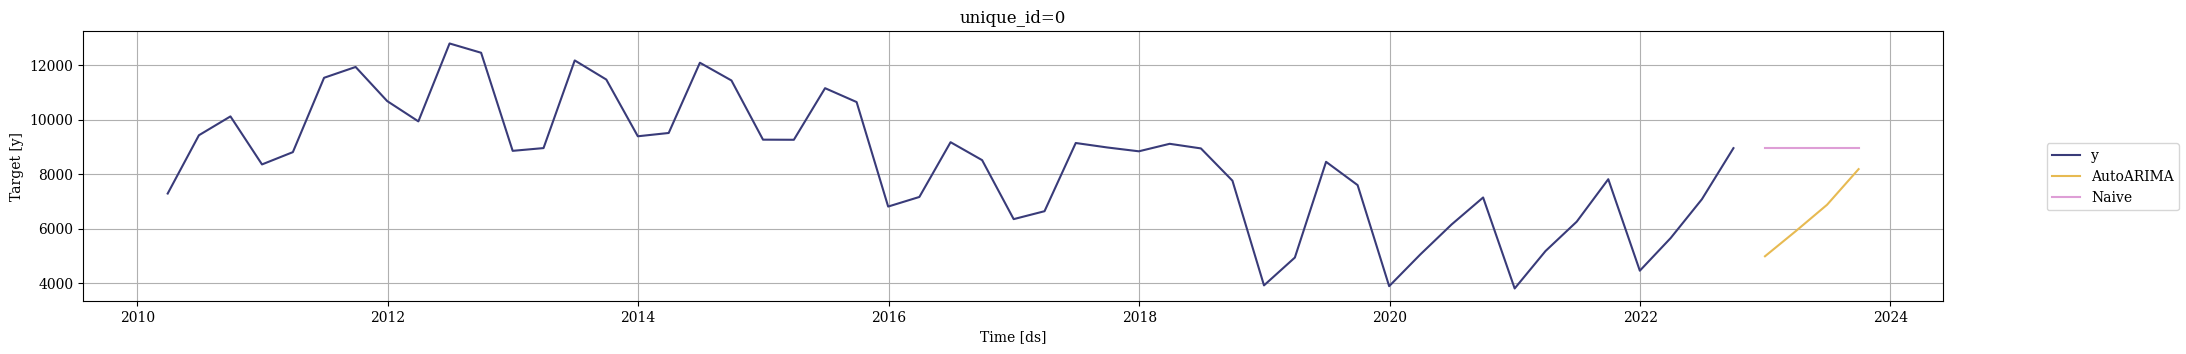

In [66]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA", "Naive"],
    unique_ids=["0"],
)

## Hierarchical reconciliation

In [90]:
hrec = HierarchicalReconciliation(reconcilers=[BottomUp(), TopDown(method="forecast_proportions")])

In [91]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [94]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

In [101]:
show_grid(plot_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

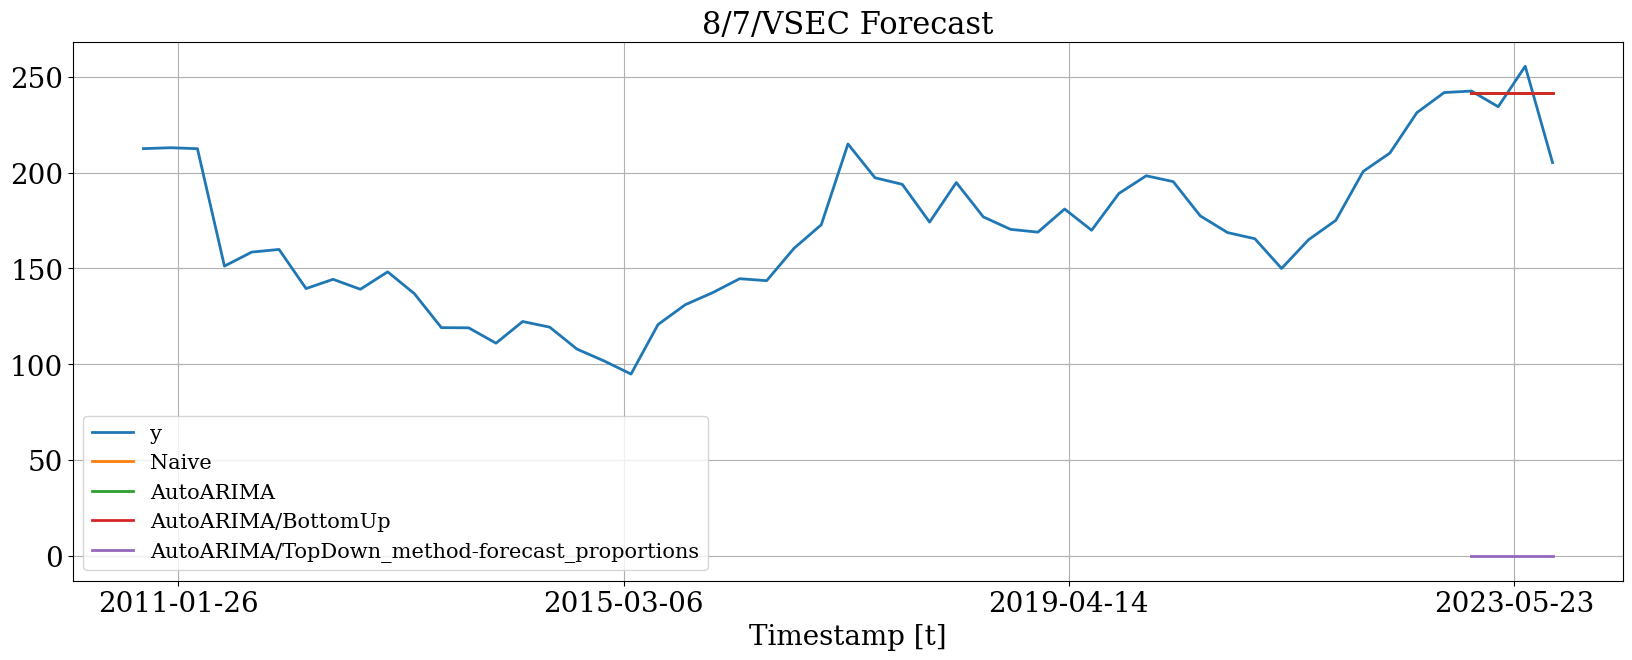

In [113]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_series(
    series="8/7/VSEC",
    Y_df=plot_df,
    models=[
        "y",
        "Naive",
        "AutoARIMA",
        "AutoARIMA/BottomUp",
        "AutoARIMA/TopDown_method-forecast_proportions",
    ],
    level=[80],
)

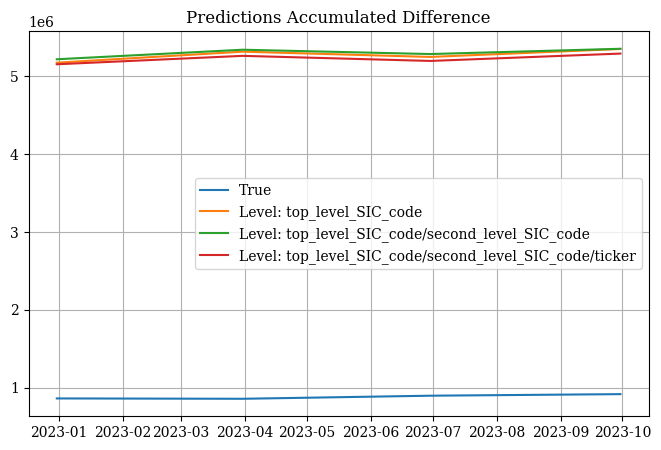

In [99]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
difference_df = Y_hat_df.merge(Y_test_df, on=["unique_id", "ds"])[
    ["ds", "AutoARIMA", "y"]
]
# hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

hplot.plot_hierarchical_predictions_gap(difference_df)

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [108]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    Y_df=Y_train_df,
    tags=tags,
    benchmark="AutoARIMA",
)

In [109]:
evaluation.T

level,Overall,top_level_SIC_code,top_level_SIC_code/second_level_SIC_code,top_level_SIC_code/second_level_SIC_code/ticker
metric,mse-scaled,mse-scaled,mse-scaled,mse-scaled
AutoARIMA,1.0,1.0,1.0,1.0
Naive,0.752905,0.826343,0.634512,1.004527
AutoARIMA/BottomUp,0.832734,0.957672,0.672709,1.0
Naive/BottomUp,0.752905,0.826344,0.634512,1.004527
AutoARIMA/TopDown_method-forecast_proportions,97.125878,158.247681,40.716579,41.105853
Naive/TopDown_method-forecast_proportions,97.137561,158.252379,40.733535,41.131335
